In [1]:
pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.9_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from collections import Counter

In [3]:
class Game:
    def __init__(self):
        # Initialize Q-table with all zeros
        self.q_table = dict()
        print(self.q_table)
        # Q-learning related variables
        self.alpha = 0.01 # learning rate
        self.gamma = 0.5 # discount factor
        self.epsilon = .1 # exploration rate
        self.action_space = [0, 1]
        self.previous_action = None
        self.initialize_deck()

    def initialize_deck(self):
        #Set up the deck
        self.card_categories = ['Hearts','Diamonds','Clubs','Spades']
        self.cards_list = ['Ace','2','3','4','5','6','7','8','9','10','Jack','Queen','King']
        self.deck = [(card,category) for category in self.card_categories for card in self.cards_list]
    def update_q_value(self, state, action, reward, next_state):
        # Get next state's Q-values
        next_q_values = dict()
        for next_action in self.action_space:
            next_q_values[next_action] = self.q_table.get((next_state, next_action), 0)
        # print("Updating Q-table for state:", state, "action:", action, "reward:", reward, "next_state:", next_state)

    
        # Calculate Q-value update
        max_next_q_value = max(next_q_values.values())
        self.q_table[(state, action)] = self.q_table.get((state, action), 0) + \
            self.alpha * (reward + self.gamma * max_next_q_value - self.get_reward(state,action))
    #returns total value given cards
    def total_card_value(self,cards):
        sum = 0
        ace_count = 0
        for card in cards:
            if card == 11:
                if sum +11<22:
                    ace_count += 1
                    sum += 11
                else:
                    sum += 1
            else:
                sum += card
            #If sum hit 21 later, use aces as 1s not 11s
            while(sum > 21 and ace_count >1):
                sum -=10
        return sum
    def get_reward(self,state,action):
        try:
            return self.q_table[(state,action)]
        except:
            return 0
    def choose_action(self, state):
        # if random.random() < self.epsilon:
        #     # Explore: choose a random action
        #     action = random.choice(self.action_space)
        # else:
        #     # Exploit: choose the action with the highest Q-value
        #     try:
        #         action = max(self.action_space, key=lambda a: self.q_table.get((state, a), 0))
        #     except ValueError:
        #         # Handle the case where the Q-table has no entries for any action in this state
        #         action = random.choice(self.action_space)
      
        exploration_bonus = 1.0
    
        for action in self.action_space:
            if self.q_table.get((state, action)) is None:
                self.q_table[(state, action)] = 0
    
        if random.random() < self.epsilon:
            # Explore: choose a random action
            action = random.choice(self.action_space)
        else:
            # Exploit: choose the action with the highest Q-value plus exploration bonus
            max_q_value = max(self.q_table.get((state, a)) + exploration_bonus for a in self.action_space)
            action = max(self.action_space, key=lambda a: self.q_table.get((state, a)) + exploration_bonus)


        # Return chosen action for further processing
        return action
    def give_card(self):
        vals = [1,2,3,4,5,6,7,8,9,10,10,10,11]
        random.shuffle(vals)
        return vals.pop()
    def play(self):
        self.initialize_deck()
        random.shuffle(self.deck)
        player_card = [self.give_card(),self.give_card()]
        dealer_card = [self.give_card(),self.give_card()]
        reward = 0
        #play the game
        while True:
            player_score = 0
            player_score = self.total_card_value(player_card)
            dealer_score = self.total_card_value(dealer_card)
            if player_score > 21:
                reward =-1
            # Get current state
            state = self.get_state(player_card, dealer_card)
        
            # Choose and take action
            choice = self.choose_action(state)
        
            # Observe next state and reward
            next_state = self.get_state(player_card, dealer_card)
            # reward = self.calculate_reward()
        
            # Update Q-table
            self.update_q_value(state, choice, reward, next_state)

            # print("Cards Player Has:", player_card)
            # print("Score Of The Player:", player_score)
        
            if choice == 0:
                new_card = self.give_card()
                player_card.append(new_card)
            elif choice == 1:
                break
            else:
                # print("invalid choice try again")
                continue
            # print("Player score:",player_score)
            if player_score > 21:
                reward = -1
                # print("Dealer had:", dealer_card)
                # print("reward: ",reward)
                return reward
                
        while dealer_score < 17 and reward ==0:
            new_card = self.give_card()
            dealer_card.append(new_card)
            dealer_score = self.total_card_value(dealer_card)
        if dealer_score > 21:
            reward =2
        elif player_score > dealer_score:
            reward=2
        elif dealer_score > player_score:
            reward=-1
        else:
            reward = 0
        # print("Dealer had:", dealer_card)
        # print("reward: ",reward)
        
        return reward
    def get_state(self, player_card, dealer_card):
        player_score = self.total_card_value(player_card)
        dealer_score = self.total_card_value(dealer_card)
        usable_ace = False
        if 'Ace' in player_card and player_score + 11 <= 21:
            usable_ace = True
        previous_action = self.previous_action  # Assuming this returns "Hit" or "Stand"
        if self.previous_action is None:
            previous_action = 0  # Default to 0 if no previous action available
        return (player_score, dealer_score, usable_ace, previous_action)
    def train(self, num_games):
        # Train the agent for a specified number of games
        print("Starting training")
        reward = []
        for _ in range(num_games):
            reward.append(self.play())
        print("HERE")
        # Define figure and axes
        fig, ax = plt.subplots()
        
        # Plot the rewards
        # ax.plot(reward)
        
        # Set labels and title
        ax.set_xlabel("Game Number")
        ax.set_ylabel("Average Reward")
        ax.set_title("Reward Over Time")
        
        # Add grid lines for better visualization
        ax.grid(True)
        smoothed_reward = savgol_filter(reward, window_length=10, polyorder=1)

        # # Plot the smoothed reward
        # ax.plot(smoothed_reward)
        ax.plot(np.arange(1, len(smoothed_reward) + 1), smoothed_reward)

        # # Show the plot
        plt.show()
        # Create a Counter object to count the occurrences of each reward
        reward_counts = Counter(reward)
        
        # Print the number of times each reward was selected
        for reward, count in reward_counts.items():
          print(f"Reward {reward} occurred {count} times ({count/num_games}%")
        print("CODE IS DONE")
        

{}
Starting training
HERE


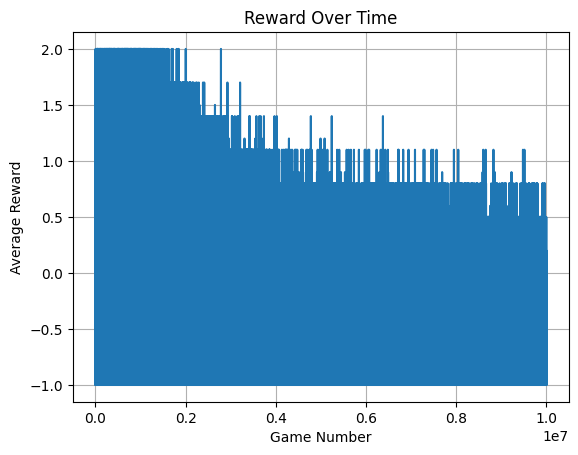

Reward -1 occurred 7976307 times (0.7976307%
Reward 2 occurred 1963206 times (0.1963206%
Reward 0 occurred 60487 times (0.0060487%
CODE IS DONE


In [4]:
# Train for 1000 games
game = Game()
game.train(10_000_000)